# fastTextによる分類

fastTextは分類器の学習もサポートしていており、単語埋め込みも含めて学習することで精度の向上が期待できます。

```{note}
fastTextを使うためには事前にfasttextパッケージをインストールしておきます。

    !pip install fasttext==0.9.1
```

データの準備をします。

In [1]:
import pandas as pd
from sklearn import model_selection

# positive, neutral, negative の中から negative なレビューを当てるタスクとして、
# negativeを1に、それ以外のpositive, neutralを0に設定します。
data = pd.read_csv("input/pn_same_judge.csv")
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

In [2]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.text for token in nlp(text)]

2022-05-09 08:01:08.876235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 08:01:08.876321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## ラベルの準備

fastTextが必要とするラベルを付与します。

In [3]:
def apply_fn(row):
    tokens = " ".join(tokenize(row["text"]))

    label = f"__label__{row['label_num']}"
    return f"{label} {tokens}"

In [4]:
for target in [train, test]:
    target["model_input"] = target.apply(apply_fn, axis="columns")

In [5]:
train.head(n=3)

,label,text,judges,label_num,model_input
2310,positive,また利用したいホテルである。,"{""1"": 3}",0,__label__0 また 利用 し たい ホテル で ある 。
308,positive,お腹いっぱい食べてしまいました。,"{""1"": 3}",0,__label__0 お腹 いっぱい 食べ て しまい まし た 。
684,negative,とにかく狭い。,"{""-1"": 3}",1,__label__1 とにかく 狭い 。


In [6]:
test.head(n=3)

,label,text,judges,label_num,model_input
3574,positive,当日貸切状態で、最高の部屋を用意していただきました。,"{""1"": 3}",0,__label__0 当日 貸切 状態 で 、 最高 の 部屋 を 用意 し て いただき ...
1386,neutral,マタニティ旅行で利用しました。,"{""0"": 3}",0,__label__0 マタニティ 旅行 で 利用 し まし た 。
499,positive,コンビニも近いです。,"{""1"": 3}",0,__label__0 コンビニ も 近い です 。


ファイルに保存します。

In [7]:
train[["model_input"]].to_csv("input/pn_ft_train.csv", header=None, index=None)
test[["model_input"]].to_csv("input/pn_ft_test.csv", header=None, index=None)

In [8]:
!head -n3 input/pn_ft_train.csv

__label__0 また 利用 し たい ホテル で ある 。
__label__0 お腹 いっぱい 食べ て しまい まし た 。
__label__1 とにかく 狭い 。


In [9]:
!head -n3 input/pn_ft_test.csv

__label__0 当日 貸切 状態 で 、 最高 の 部屋 を 用意 し て いただき まし た 。
__label__0 マタニティ 旅行 で 利用 し まし た 。
__label__0 コンビニ も 近い です 。


## 学習する

In [10]:
import fasttext

model = fasttext.train_supervised(input="input/pn_ft_train.csv")

Read 0M words
Number of words:  3358
Number of labels: 2
Progress: 100.0% words/sec/thread: 2453796 lr:  0.000000 loss:  0.221002 ETA:   0h 0m


In [11]:
model.test("input/pn_ft_test.csv")

(419, 0.9021479713603818, 0.9021479713603818)

In [12]:
def prob_fn(item):
    input_text = " ".join(item.split()[1:])
    pred = model.predict(input_text)
    label = pred[0][0]
    score = pred[1][0]
    if label == "__label__1":
        pass
    elif label == "__label__0":
        score = 1 - score
    else:
        raise Exception(f"Label is not expected one: {label}")
    label_map = {"__label__1": 1, "__label__0": 0}
    return label_map[label], score

pred = test["model_input"].apply(lambda x: prob_fn(x)[0])
score = test["model_input"].apply(lambda x: prob_fn(x)[1])

In [13]:
pred.head()

3574    0
1386    0
499     0
3756    0
914     0
Name: model_input, dtype: int64

In [14]:
score.head()

3574    0.020941
1386    0.000616
499     0.011643
3756    0.024373
914     0.018029
Name: model_input, dtype: float64

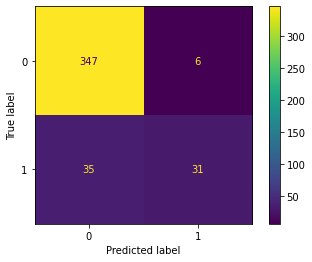

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred)

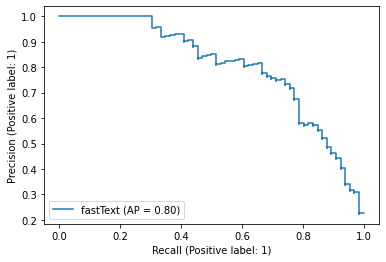

In [16]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_true=test["label_num"], y_pred=score, name="fastText")